# Avito demand prediction challenge

This notebook contains code that makes single-model prediction that scores ~0.2195 on public leaderboard.

Notebook contains data processing, some simple features, cross-validation and submission generation. Most of the features take a while to calculate, so I calculate them in separate notebooks, cache them in .pickle files, and just load here. Running all notebooks from scratch would take ~4 days on my machine (64 Gb RAM, 8 cores, GPU).

I'm not great at explaining things; comments and suggestions are appreciated.

This is my first time seriously (=not just submitting baseline) participating in Kaggle competition. I stood on shoulders of titans:
 - Initially forked from Bojan's kernel here: https://www.kaggle.com/tunguz/bow-meta-text-and-dense-features-lb-0-2242/code
 - improvement using kernel from Nick Brook's kernel here: https://www.kaggle.com/nicapotato/bow-meta-text-and-dense-features-lgbm
 - Used oof method from Faron's kernel here: https://www.kaggle.com/mmueller/stacking-starter?scriptVersionId=390867
 - TargetEncoder by [samratp](https://www.kaggle.com/samratp/wordbatch-ridge-fm-frtl-target-encoding-lgbm) and [ogrellier](https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features)
 - ODS community (many ideas and suggestions)


#### Contents:

1. [Settings, imports](#Settings-and-imports)
2. [Data loading](#Data-loading)
3. Features
  - [Date and price features](#Date-and-price-features)
  - [User features](#User-features)
  - [Image features](#Image-features)
  - [City/region-level external data](#City-and-region-extra-data)
  - [Nearest-neighbour - based features](#KNN-features)
  - [Text features](#Text-features)
  - [Similarity features](#Similarity-features)
4. [Encoding categorial variables](#Encoding-categorial-variables)
5. [Making train/test sets](#Building-train-test-sets)
6. [Running single model and estimating tree count](#Running-single-model)
7. [Using folds to make final prediction](#Using-folds)

# Settings and imports
The script expects `base_path` to be a directory that contains unpacked csv files, `train_image_base_path` and `test_image_base_path` to be directories that contain unpacked train and test images respectively.

In [1]:
base_path = "~/.kaggle/competitions/avito-demand-prediction/"
train_image_base_path = base_path + "data/competition_files/train_jpg/"
test_image_base_path = base_path + "data/competition_files/test_jpg/"

In [2]:
import time

import pickle
import numpy as np
import pandas as pd
import os
import gc

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb
from sklearn.linear_model import Ridge
from sklearn.cross_validation import KFold

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack, csr_matrix
from nltk.corpus import stopwords 

import matplotlib.pyplot as plt
import re
import string

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
NFOLDS = 5
SEED = 42

class TargetEncoder:
    # Adapted from https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
    def __repr__(self):
        return 'TargetEncoder'

    def __init__(self, cols, smoothing=1, min_samples_leaf=1, noise_level=0, keep_original=False):
        self.cols = cols
        self.smoothing = smoothing
        self.min_samples_leaf = min_samples_leaf
        self.noise_level = noise_level
        self.keep_original = keep_original

    @staticmethod
    def add_noise(series, noise_level):
        return series * (1 + noise_level * np.random.randn(len(series)))

    def encode(self, train, test, target):
        for col in self.cols:
            if self.keep_original:
                train[col + '_te'], test[col + '_te'] = self.encode_column(train[col], test[col], target)
            else:
                train[col], test[col] = self.encode_column(train[col], test[col], target)
        return train, test

    def encode_column(self, trn_series, tst_series, target):
        temp = pd.concat([trn_series, target], axis=1)
        # Compute target mean
        averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
        # Compute smoothing
        smoothing = 1 / (1 + np.exp(-(averages["count"] - self.min_samples_leaf) / self.smoothing))
        # Apply average function to all target data
        prior = target.mean()
        # The bigger the count the less full_avg is taken into account
        averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
        averages.drop(['mean', 'count'], axis=1, inplace=True)
        # Apply averages to trn and tst series
        ft_trn_series = pd.merge(
            trn_series.to_frame(trn_series.name),
            averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
            on=trn_series.name,
            how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
        # pd.merge does not keep the index so restore it
        ft_trn_series.index = trn_series.index
        ft_tst_series = pd.merge(
            tst_series.to_frame(tst_series.name),
            averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
            on=tst_series.name,
            how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
        # pd.merge does not keep the index so restore it
        ft_tst_series.index = tst_series.index
        return self.add_noise(ft_trn_series, self.noise_level), self.add_noise(ft_tst_series, self.noise_level)

class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None, seed_bool = True):
        if(seed_bool == True):
            params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
        
def get_oof(clf, x_train, y, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        print('\nFold {}'.format(i))
        x_tr = x_train[train_index]
        y_tr = y[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

# Data loading

In [4]:
training = pd.read_csv(base_path + 'train.csv', index_col = "item_id", parse_dates = ["activation_date"])
testing = pd.read_csv(base_path + 'test.csv', index_col = "item_id", parse_dates = ["activation_date"])

testing_users = testing["user_id"]
training_users = training["user_id"]


traindex = training.index
testdex = testing.index

ntrain = training.shape[0]
ntest = testing.shape[0]

y = training.deal_probability.copy()
training.drop("deal_probability",axis=1, inplace=True)

df = pd.concat([training, testing],axis=0)
del training, testing
gc.collect()

35

# Date and price features
Applying log-transform to the price, so its distribution would appear normal-ish.

NaNs are filled with mean (filling it with mean by category reduced my score for some reason).

In [5]:
df["price"] = np.log(df["price"] + 0.001)
df["price_empty"] = df["price"].isnull().astype(np.float)
df["price"].fillna(df["price"].mean(skipna=True), inplace=True)

In [6]:
df["Weekday"] = df['activation_date'].dt.weekday

### Price features in categories

In [7]:
df["image_top_1"].fillna(-999,inplace=True)
df["image_top_1"] = df["image_top_1"].apply(lambda x: int(round(x)))

In [8]:
def make_col_from_dict(x, y, default = -1.0):
    l = np.zeros((len(x)))
    for r, i in enumerate(x.values):
        l[r] = y.get(tuple(i), default)
    return pd.Series(l, index=x.index)

def make_col_from_dict_untupled(x, y, default = -1.0):
    l = np.zeros((len(x)))
    for r, i in enumerate(x.values):
        l[r] = y.get(i, default)
    return pd.Series(l, index=x.index)

In [9]:
# Raw price features 
cat_params = ["parent_category_name", "category_name", "image_top_1"]
for extra_columns in [[], ["region"], ["city"]]:
    for col in cat_params:
        name_prefix = "_".join([col] + extra_columns)
        
        print(name_prefix)
        means = df.groupby([col] + extra_columns)["price"].mean().to_dict()
        medians = df.groupby([col] + extra_columns)["price"].median().to_dict()
        counts = df.groupby([col] + extra_columns)["price"].count().to_dict()
        var = df.groupby([col] + extra_columns)["price"].var().to_dict()

        df[name_prefix + "_mean_price"] = make_col_from_dict(df[[col] + extra_columns], means)
        df[name_prefix + "_median_price"] = make_col_from_dict(df[[col] + extra_columns], medians)
        df[name_prefix + "_counts"] = make_col_from_dict(df[[col] + extra_columns], counts)
        df[name_prefix + "_var_price"] = make_col_from_dict(df[[col] + extra_columns], var).fillna(0.0) # Var may have zero variance if there is single row

parent_category_name
category_name
image_top_1
parent_category_name_region
category_name_region
image_top_1_region
parent_category_name_city
category_name_city
image_top_1_city


# User features

In [10]:
def get_user_feature_map():
    # Loading data
    used_cols = ["item_id", "user_id", "parent_category_name", "category_name", "price"]

    train = pd.read_csv(base_path + 'train.csv', usecols=used_cols)
    train_active = pd.read_csv(base_path + 'train_active.csv', usecols=used_cols)
    test = pd.read_csv(base_path + 'test.csv', usecols=used_cols)
    test_active = pd.read_csv(base_path + 'test_active.csv', usecols=used_cols)

    all_samples = pd.concat([
        train,
        train_active,
        test,
        test_active
    ]).reset_index(drop=True)
    all_samples.drop_duplicates(['item_id'], inplace=True)

    del train_active, test_active, train, test
    gc.collect()

    train_periods = pd.read_csv(base_path + 'periods_train.csv', parse_dates=['date_from', 'date_to'])
    test_periods = pd.read_csv(base_path + 'periods_test.csv', parse_dates=['date_from', 'date_to'])

    all_periods = pd.concat([
        train_periods,
        test_periods
    ])

    del train_periods
    del test_periods
    gc.collect()

    # Calculating how many times / for how long each item_id was put on site
    all_periods['days_up'] = all_periods['date_to'].dt.dayofyear - all_periods['date_from'].dt.dayofyear
    gp = all_periods.groupby(['item_id'])[['days_up']]
    item_up_features = pd.DataFrame()
    item_up_features['days_up_sum'] = gp.sum()['days_up']
    item_up_features['times_put_up'] = gp.count()['days_up']
    item_up_features.reset_index(inplace=True)
    item_up_features.rename(index=str, columns={'index': 'item_id'})

    all_periods.drop_duplicates(['item_id'], inplace=True)
    all_periods = all_periods.merge(item_up_features, on='item_id', how='left')
    all_periods = all_periods.merge(all_samples, on='item_id', how='left')

    gp = all_periods.groupby(['user_id'])[['days_up_sum', 'times_put_up']].mean().reset_index() \
    .rename(index=str, columns={
        'days_up_sum': 'avg_days_up_user',
        'times_put_up': 'avg_times_up_user'
    })

    n_user_items = all_samples.groupby(['user_id'])[['item_id']].count().reset_index() \
    .rename(index=str, columns={
        'item_id': 'n_user_items'
    })
    gp = gp.merge(n_user_items, on='user_id', how='outer')

    user_features = gp.groupby("user_id").mean().to_dict()
    return user_features

In [11]:
if os.path.isfile("user_features.pickle"):
    print("Loading cached user features")
    with open("user_features.pickle", "rb") as f:
        user_features = pickle.load(f)
else:
    print("Calculating and caching user features")
    user_features = get_user_feature_map()
    with open("user_features.pickle", "wb") as f:
        pickle.dump(user_features, f)

Loading cached user features


In [12]:
for x in ["avg_days_up_user", "avg_times_up_user", "n_user_items"]:
    df[x] = make_col_from_dict_untupled(df['user_id'], user_features[x])
    df[x].fillna(-1.0, inplace=True)

In [13]:
del user_features
gc.collect()

49

# Date/region/city features
I'll clean this mess

In [14]:
df_active = pd.read_csv(base_path + "train_active.csv", parse_dates=["activation_date"], 
                        usecols=["region", "city", "category_name", "item_id", "activation_date"])
df_active.set_index("item_id", inplace=True)

In [37]:
df_active_test = pd.read_csv(base_path + "test_active.csv", parse_dates=["activation_date"], 
                             usecols=["region", "city", "category_name", "item_id", "activation_date"])
df_active_test.set_index("item_id", inplace=True)

In [38]:
df_active = pd.concat([df_active, df_active_test])
del df_active_test

Periods

In [39]:
df_periods = pd.read_csv(base_path + "periods_train.csv", parse_dates = ["date_from", "date_to"],
                        usecols = ["item_id", "date_from", "date_to"])
df_periods.set_index("item_id", inplace=True)

In [40]:
df_periods_test = pd.read_csv(base_path + "periods_test.csv", parse_dates = ["date_from", "date_to"],
                        usecols = ["item_id", "date_from", "date_to"])
df_periods_test.set_index("item_id", inplace=True)

In [41]:
df_periods = pd.concat([df_periods, df_periods_test])
del df_periods_test

Merging, making features

In [42]:
joined = df_active.join(df_periods)
del df_periods, df_active
gc.collect()

186

In [43]:
joined.reset_index(inplace=True)

In [44]:
joined["date_diff"] = joined["date_to"].dt.dayofyear - joined["date_from"].dt.dayofyear

In [45]:
repeats = joined.groupby("item_id")["region"].count().to_dict()
joined["repeats"] = joined["item_id"].apply(lambda x: repeats.get(x))

In [46]:
from scipy.stats import describe
joined["date_diff"].fillna(-1.0, inplace=True)

In [47]:
with open("date_features.pickle", "wb") as f:
    pickle.dump(joined, f)

### Applying features

In [15]:
with open("date_features.pickle", "rb") as f:
    joined = pickle.load(f)

In [16]:
print("Region")
reg_cat = joined.groupby(["region", "category_name"])
reg_cat_diff = reg_cat["date_diff"].mean().to_dict()
reg_cat_count = reg_cat["date_diff"].count().to_dict()
reg_cat_repeats = reg_cat["repeats"].mean().to_dict()

print("City")
city_cat = joined.groupby(["city", "category_name"])
city_cat_diff = city_cat["date_diff"].mean().to_dict()
city_cat_count = city_cat["date_diff"].count().to_dict()
city_cat_repeats = city_cat["repeats"].mean().to_dict()

print("Just category")
just_cat = joined.groupby(["category_name"])
just_cat_diff = just_cat["date_diff"].mean().to_dict()
just_cat_count = just_cat["date_diff"].count().to_dict()
just_cat_repeats = just_cat["repeats"].mean().to_dict()

Region
City
Just category


In [17]:
df["category_date_diff"] = df["category_name"].apply(lambda x: just_cat_diff.get(x, -1.0))
df["category_count"] = df["category_name"].apply(lambda x: just_cat_count.get(x, -1.0))
df["category_repeats"] = df["category_name"].apply(lambda x: just_cat_repeats.get(x, -1.0))

df["region_category_date_diff"] = make_col_from_dict(df[["region", "category_name"]], reg_cat_diff)
df["region_category_repeats"] = make_col_from_dict(df[["region", "category_name"]], reg_cat_repeats)
df["region_category_counts"] = make_col_from_dict(df[["region", "category_name"]], reg_cat_count)

df["city_category_date_diff"] = make_col_from_dict(df[["city", "category_name"]], city_cat_diff)
df["city_category_repeats"] = make_col_from_dict(df[["city", "category_name"]], city_cat_repeats)
df["city_category_counts"] = make_col_from_dict(df[["city", "category_name"]], city_cat_count)

In [18]:
df.drop(["activation_date"], axis=1, inplace=True)

In [19]:
del joined

# Image features
Image features are the most computational-intensive features in this notebook. They are calculated in separate (img_features.ipynb)[notebook].

In [20]:
def load_pairs(filenames):
    d = {}
    for f in filenames:
        with open(f, "rb") as f:
            while True:
                try:
                    pair = pickle.load(f)
                    d[pair[0]] = np.array(pair[1])
                except EOFError:
                    break
    return d, len(pair[1])

def append_feature_pairs(df, image_col, pair_dict, pair_len, feature_names):
    zero_obj = -np.ones((pair_len))
    packed_images_vectors = image_col.apply(lambda x: pair_dict.get(str(x), zero_obj))
    df[feature_names] = pd.DataFrame(packed_images_vectors.values.tolist(), index=df.index)

### Dense vectors

In [21]:
image_vectors_dense, p_len = load_pairs(["vectors_compacted1300k.pickle"])
dense_img_vec_names = [str(x + 1) + "_dense_img_vector" for x in range(p_len)]
append_feature_pairs(df, df["image"] + ".jpg", image_vectors_dense, p_len, dense_img_vec_names)
del image_vectors_dense

### Image basic parameters (class, size, average colors etc)

In [22]:
feature_dict, p_len = load_pairs([str(x) + "_img.pickle" for x in range(8)])
simple_img_features = [
    "blurrness", 
    "size", "dims",
    "w", "h", 
    "avg_color_r", "avg_color_g", "avg_color_b",
    "pixel_w",
    "light", "darkness", "img_class", "img_proba"]

append_feature_pairs(df, df["image"], feature_dict, p_len, simple_img_features)
del feature_dict

In [23]:
# :)
df["img_class"] = df["img_class"].apply(lambda x: int(round(x)))

### Palette features

In [24]:
image_pal_dict, p_len = load_pairs([str(x) + "_pal.pickle" for x in range(16)])
pal_feature_names = [
    "cful",
    "dom1y", "dom1u", "dom1v",
    "dom2y", "dom2u", "dom2v",
    "dom1portion", "dom2portion",
    "ymean", "umean", "vmean",
    "yvar", "uvar", "vvar",
    "hmean", "lmean", "smean",
    "hvar", "lvar", "svar",
]

append_feature_pairs(df, df["image"] + ".jpg", image_pal_dict, p_len, pal_feature_names)
del image_pal_dict

### Image segmentation features

In [25]:
image_seg_dict, p_len = load_pairs(["segment_features.pickle"])
seg_feature_names = ['kp5',
 'kp10',
 'kp20',
 'mask_size_64',
 'contour_size_64',
 'largest_contour_size_64',
 'contours_64_larger_5',
 'contours_64_larger_100',
 'contours_64_larger_500',
 'mask_size_128',
 'contour_size_128',
 'largest_contour_size_128',
 'contours_128_larger_5',
 'contours_128_larger_100',
 'contours_128_larger_500',
 'mask_size_192',
 'contour_size_192',
 'largest_contour_size_192',
 'contours_192_larger_5',
 'contours_192_larger_100',
 'contours_192_larger_500']

append_feature_pairs(df, df["image"] + ".jpg", image_seg_dict, p_len, seg_feature_names)
del image_seg_dict

### Clean-up
Some features have NaNs or Infs in them. Let's fill these

In [26]:
for col in simple_img_features + pal_feature_names + seg_feature_names:
    df.loc[~np.isfinite(df[col]), col] = -1.0
# df[["image"] + pal_feature_names + simple_img_features + dense_img_vec_names].to_csv("img_export.csv")
df.drop(["image"], axis=1, inplace=True)

# City and region extra data
Adding extra features provided by my teammates. These numbers were crawled from Wikipedia, and add (subtract :) few extra scoring points

In [27]:
city_pop = pd.read_csv("city_population_wiki_v3.csv")
city_pop = city_pop.groupby("city")["population"].mean().to_dict()

In [28]:
df["city_pop"] = df["city"].apply(lambda x: city_pop.get(x, -1.0))

In [29]:
region_stats = pd.read_csv("zarplata2.csv")
def preproc_region(x):
    return x.lower().replace("обл.", "").replace("область", "").replace(" ", "")
region_stats["region"] = region_stats["region"].apply(preproc_region)
region_stats = region_stats.groupby("region").mean().to_dict()

In [30]:
for x in ["zarplata","woman","mduh","mtrud","mpens","mdet"]:
    df[x] = df["region"].apply(lambda y: region_stats[x].get(preproc_region(y), -1.0))

In [31]:
del region_stats, city_pop

# Text features

### Simple character/word-level feautres
How many words/specific character there are in description/title

In [32]:
def count_consecutive_upper(x):
    tops = 0
    current = 0
    last = False
    for l in x:
        if l.isupper():
            current += 1
            last = True
        else:
            if last:
                last = False
                tops = max(current, tops)
                current = 0
    return max(current, tops)

In [33]:
import re
import string
nonascii_pattern = re.compile('[\x00-\x7f]')

for col in ["description", "title"]:
    df[col] = df[col].fillna("")
    print(col + "...")
    df[col + "_tokens"] = df[col].apply(lambda x: len(x.split()))
    df[col + "_consecutive_"] = df[col].apply(lambda x: count_consecutive_upper(x))
    df[col + "_len"] = df[col].apply(lambda x: len(x))
    df[col + "_upper"] = df[col].apply(lambda x: sum([y.isupper() for y in x]))
    df[col + "_upper_frac"] = df[col + "_upper"] / (df[col + "_len"] + 0.001)
    df[col + "_punct"] = df[col].apply(lambda x: sum([y in string.punctuation for y in x]))
    df[col + "_punct_frac"] = df[col + "_punct"] / (df[col + "_len"] + 0.001)
    df[col + "_special"] = df[col].apply(lambda x: len(re.sub(nonascii_pattern, '', x)))
    df[col + "_special_frac"] = df[col + "_special"] / (df[col + "_len"] + 0.001)
    if col == "description":
        df.drop("description_upper", axis = 1, inplace = True)
        df.drop("description_punct", axis = 1, inplace = True)
    if col == "title":
        df.drop("title_upper", axis = 1, inplace = True)
        df.drop("title_punct", axis = 1, inplace = True)

description...
title...


### SVD/BOW features
Stemming slightly improves score, but takes a while to calculate, so I stem words and cache results in [separate notebook](stemming.ipynb).

In [34]:
import pickle

with open("stemmed.pickle", "rb") as f:
    title_stemmed, description_stemmed, params_stemmed = pickle.load(f)
    
df["title_stemmed"] = pd.Series(title_stemmed, df.index)
df["description_stemmed"] = pd.Series(description_stemmed, df.index)
df["params_stemmed"] = pd.Series(params_stemmed, df.index)

del title_stemmed, description_stemmed, params_stemmed

### SVD
Idea is rather simple: create TF-IDF matrices and compact them into dense representations using truncated SVD. Such dense representations capture most of the variance of the original TF-IDF matrix, so we can say that it extracts "patterns" from it, and estimates how close each title/description to each pattern.

I run title/description/param SVDs separately because otherwise words from lengthy descriptions will overwhelm words from title and params.



In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

def make_svd_features(df, column, features_prefix, n_comp = 15, ngram_range=(1,1), max_features=25000):
    print(features_prefix)
    tfidf_vec = TfidfVectorizer(ngram_range = ngram_range, max_features=max_features)
    full_tfidf = tfidf_vec.fit_transform(df[col].fillna("").values.tolist())

    svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
    svd_obj.fit(full_tfidf)
    df_svd = pd.DataFrame(svd_obj.transform(full_tfidf))
    df_svd.columns = [features_prefix + "_" + str(i+1) for i in range(n_comp)]
    df_svd.set_index(df.index, inplace=True)
    df[df_svd.columns] = df_svd

In [36]:
make_svd_features(df, df["description_stemmed"], "svd_description_stemmed")
make_svd_features(df, df["title_stemmed"], "svd_title_stemmed")
make_svd_features(df, df["params_stemmed"], "svd_params_stemmed")

svd_description_stemmed
svd_title_stemmed
svd_params_stemmed


### BOW + prediction
I should rewrite this mess

In [112]:
print("\n[TF-IDF] Term Frequency Inverse Document Frequency Stage")
russian_stop = set(stopwords.words('russian')) | set(stopwords.words('english'))

tfidf_para = {
    "stop_words": russian_stop,
    "analyzer": 'word',
    "token_pattern": r'\w{1,}',
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": 'l2',
    #"min_df":5,
    #"max_df":.9,
    "smooth_idf":False
}


def get_col(col_name): return lambda x: x[col_name]
##I added to the max_features of the description. It did not change my score much but it may be worth investigating
vectorizer = FeatureUnion([
    ('description_stemmed', TfidfVectorizer(
        ngram_range=(1, 2),
        max_features=25000,
        **tfidf_para,
        preprocessor=get_col('description_stemmed'))),
    ('title_stemmed', TfidfVectorizer(
        ngram_range=(1, 2),
        stop_words = russian_stop,
        preprocessor=get_col('title_stemmed'))),
    ('params_stemmed', CountVectorizer(
        ngram_range=(1, 2),
        stop_words = russian_stop,
        preprocessor=get_col('params_stemmed')))
])

start_vect=time.time()

#Fit my vectorizer on the entire dataset instead of the training rows
#Score improved by .0001
vectorizer.fit(df.to_dict('records'))

ready_df = vectorizer.transform(df.to_dict('records'))
sparse_vocab = vectorizer.get_feature_names()
print("Vectorization Runtime: %0.2f Minutes"%((time.time() - start_vect)/60))


[TF-IDF] Term Frequency Inverse Document Frequency Stage
Vectorization Runtime: 15.95 Minutes


In [ ]:
from sklearn.cross_validation import KFold
kf = KFold(ntrain, n_folds=NFOLDS, shuffle=True, random_state=SEED)

from sklearn.metrics import mean_squared_error
from math import sqrt

rmses = {}
best_oof = None

for alpha in np.arange(10.0, 40.0, 2.0):
    ridge_params = {'alpha': alpha, 'fit_intercept':True, 'normalize':False, 'copy_X':True,
                    'max_iter':None, 'tol':0.001, 'solver':'auto', 'random_state':SEED}

    #Ridge oof method from Faron's kernel
    #I was using this to analyze my vectorization, but figured it would be interesting to add the results back into the dataset
    #It doesn't really add much to the score, but it does help lightgbm converge faster
    ridge = SklearnWrapper(clf=Ridge, seed = SEED, params = ridge_params)
    
    ridge_oof_train, ridge_oof_test = get_oof(ridge, ready_df[:ntrain], y, ready_df[ntrain:])
    
    rms = sqrt(mean_squared_error(y, ridge_oof_train))
    rmses[alpha] = rms
    if rms == min(rmses.values()):
        best_oof = (ridge_oof_train, ridge_oof_test)
    print('Alpha: ' + str(alpha) + ' ridge OOF RMSE: {}'.format(rms))


Fold 0

Fold 1

Fold 2

Fold 3

Fold 4
Alpha: 10.0 ridge OOF RMSE: 0.2281048581285804

Fold 0

Fold 1

Fold 2

Fold 3

Fold 4
Alpha: 12.0 ridge OOF RMSE: 0.2280527873142504

Fold 0

Fold 1

Fold 2

Fold 3

Fold 4
Alpha: 14.0 ridge OOF RMSE: 0.2280304101872446

Fold 0

Fold 1

Fold 2

Fold 3

Fold 4
Alpha: 16.0 ridge OOF RMSE: 0.228026555425142

Fold 0

Fold 1

Fold 2

Fold 3

Fold 4
Alpha: 18.0 ridge OOF RMSE: 0.22803482766865815

Fold 0

Fold 1

Fold 2

Fold 3

Fold 4
Alpha: 20.0 ridge OOF RMSE: 0.22805137752093924

Fold 0

Fold 1

Fold 2

Fold 3

Fold 4
Alpha: 22.0 ridge OOF RMSE: 0.22807352974043002

Fold 0

Fold 1

Fold 2

Fold 3

Fold 4
Alpha: 24.0 ridge OOF RMSE: 0.22809959113507244

Fold 0

Fold 1

Fold 2

Fold 3

Fold 4
Alpha: 26.0 ridge OOF RMSE: 0.2281284762683046

Fold 0

Fold 1

Fold 2

Fold 3

Fold 4
Alpha: 28.0 ridge OOF RMSE: 0.22815931203386491

Fold 0

Fold 1

Fold 2

Fold 3


In [ ]:
with open("tf-idf.pickle", "wb") as f:
    pickle.dump(ready_df, f)
    pickle.dump(best_oof, f)
    pickle.dump(sparse_vocab, f)

### Using features

In [37]:
with open("tf-idf.pickle", "rb") as f:
    ready_df = pickle.load(f)
    best_oof = pickle.load(f)
    sparse_vocab = pickle.load(f)

In [38]:
ridge_oof_train, ridge_oof_test = best_oof

In [39]:
ridge_preds = np.concatenate([ridge_oof_train, ridge_oof_test])
df['ridge_preds'] = ridge_preds

In [40]:
df.drop(["title_stemmed", "description_stemmed", "params_stemmed"], axis=1,inplace=True)
df.drop(["description", "title"], axis=1,inplace=True)

# KNN features
Idea of these features: let's take some features and distance measure, and find nearest objects according to it. After that, let's extract features from those objects (price mean/variance, for example).

It takes ~30 hours to build these features from scratch. So, they are calculated in separate notebook and cached.

In [41]:
tfidf_nearest_features = pd.read_csv("tf_idf_nearest_features.csv.zip", compression="zip")
tfidf_nearest_features.set_index("item_id", inplace=True)

In [42]:
img_nearest_features = pd.read_csv("img_nearest_features.csv.zip", compression="zip")
img_nearest_features.set_index("item_id", inplace=True)

In [43]:
cat_img_nearest_features = pd.read_csv("cat_nearest_features.csv.zip", compression="zip")
cat_img_nearest_features.set_index("item_id", inplace=True)

In [44]:
df[tfidf_nearest_features.columns] = tfidf_nearest_features
df[img_nearest_features.columns] = img_nearest_features
df[cat_img_nearest_features.columns] = cat_img_nearest_features

In [45]:
for col in list(tfidf_nearest_features.columns) + list(img_nearest_features.columns) + list(cat_img_nearest_features.columns):
    df[col].fillna(-999.0, inplace=True)

Unfortunately, target features induce leaks. In future, I should use folds to properly calculate them. For now, let's just drop them.

In [46]:
to_drop = []
for col in df.columns:
    if "target" in col:
        to_drop.append(col)
if len(to_drop) > 0:
    df.drop(to_drop, axis=1, inplace=True)

In [47]:
del img_nearest_features, tfidf_nearest_features, cat_img_nearest_features
gc.collect()

119

# Similarity features
Core idea of these features is similar to the nearest neighbout-based features. But instead of calculating features from nearest neighbours, let's estimate how much particular item sticks out from his category/class according to this distance metric.

In [48]:
def make_similarity_feature(group_col, variables_to_agg):
    variables_to_agg = (variables_to_agg - variables_to_agg.mean()) / (variables_to_agg.max() - variables_to_agg.min())
    sims = np.zeros((len(group_col)))
    for x in np.unique(group_col):
        inds = np.where(group_col == x)[0]
        centroid = np.median(variables_to_agg.iloc[inds], axis=0)
        sims[inds] = np.dot(variables_to_agg.iloc[inds], centroid)
    return sims

In [49]:
def make_similarity_feature_sparse(group_col, variables_to_agg):
    variables_to_agg = (variables_to_agg - variables_to_agg.mean()) / (variables_to_agg.max() - variables_to_agg.min())
    sims = np.zeros((len(group_col)))
    for x in np.unique(group_col):
        inds = np.where(group_col == x)[0]
        centroid = np.median(variables_to_agg.iloc[inds], axis=0)
        sims[inds] = np.dot(variables_to_agg.iloc[inds], centroid)
    return sims

In [50]:
df["region_cat"] = df["region"].astype(str) + " " + df["category_name"].astype(str)
svd_description_columns = list(filter(lambda x: "svd_description" in x, list(df.columns)))
svd_title_columns = list(filter(lambda x: "svd_title" in x, list(df.columns)))

In [51]:
group_columns = ["category_name", "parent_category_name", 
                 "param_1", "param_2",
                 "image_top_1", "img_class",
                 "region_cat"]
agg_columns = [
    ("title_desc_svd", svd_description_columns + svd_title_columns),
    ("desc_vec", svd_description_columns),
    ("title_vec", svd_title_columns),
    ("image_vec", dense_img_vec_names),
    ("price", ["price"])
]

for gr in group_columns:
    for agg_n, agg_c in agg_columns:
        print("sims_" + gr + "_" + agg_n)
        sim_text = make_similarity_feature(df[gr].fillna("na"), df[agg_c])
        df["sims_" + gr + "_" + agg_n] = pd.Series(sim_text, index = df.index)

sims_category_name_title_desc_svd
sims_category_name_desc_vec
sims_category_name_title_vec
sims_category_name_image_vec
sims_category_name_price
sims_parent_category_name_title_desc_svd
sims_parent_category_name_desc_vec
sims_parent_category_name_title_vec
sims_parent_category_name_image_vec
sims_parent_category_name_price
sims_param_1_title_desc_svd
sims_param_1_desc_vec
sims_param_1_title_vec
sims_param_1_image_vec
sims_param_1_price
sims_param_2_title_desc_svd
sims_param_2_desc_vec
sims_param_2_title_vec
sims_param_2_image_vec
sims_param_2_price
sims_image_top_1_title_desc_svd
sims_image_top_1_desc_vec
sims_image_top_1_title_vec
sims_image_top_1_image_vec
sims_image_top_1_price
sims_img_class_title_desc_svd
sims_img_class_desc_vec
sims_img_class_title_vec
sims_img_class_image_vec
sims_img_class_price
sims_region_cat_title_desc_svd
sims_region_cat_desc_vec
sims_region_cat_title_vec
sims_region_cat_image_vec
sims_region_cat_price


In [52]:
df.drop(["region_cat"], axis=1, inplace=True)

# Encoding categorial variables

In [53]:
len(set(df["user_id"]) & set(testing_users)), len(set(df["user_id"]) - set(testing_users))

(306069, 703840)

In [54]:
# Droppping unneccessary levels
# df["user_id"][~df["user_id"].isin(set(testing_users))] = "Unknown"

In [55]:
categorical = ["img_class", "user_id", 
               "region","city","parent_category_name","category_name","user_type",
               "image_top_1","param_1","param_2","param_3"]

lbl = LabelEncoder()
for col in categorical:
    print(col)
    df[col] = lbl.fit_transform(df[col].fillna('Unknown').astype(str))

img_class
user_id
region
city
parent_category_name
category_name
user_type
image_top_1
param_1
param_2
param_3


### Stats to ensure that everything is OK
You might want to run this function to carefully check whether distribution of feautures in train/test are consistent.

In [56]:
def describe_columns(cols = df.columns):
    from scipy.stats import describe
    for c in cols:
        print("\n\n", c, df[c][0].__class__)
        print(c, "train:")
        print("-1: ", sum(df.loc[traindex][c] == -1))
        print(describe(df.loc[traindex][c][df.loc[traindex][c] != -1]))
        print(c, "test:")
        print("-1: ", sum(df.loc[testdex][c] == -1))
        print(describe(df.loc[testdex][c][df.loc[testdex][c] != -1]))


# Building train-test sets

In [57]:
X = hstack([csr_matrix(df.loc[traindex,:].values), ready_df[0:traindex.shape[0]]])
testing = hstack([csr_matrix(df.loc[testdex,:].values), ready_df[traindex.shape[0]:]])
tfvocab = df.columns.tolist() + sparse_vocab

for shape in [X,testing]:
    print("{} Rows and {} Cols".format(*shape.shape))

gc.collect()

1503424 Rows and 1268356 Cols
508438 Rows and 1268356 Cols


70

In [58]:
# X = np.array(df.loc[traindex,:].values)
# testing = np.array(df.loc[testdex,:].values)
# tfvocab = df.columns.tolist() # + tfvocab
# 
# for shape in [X,testing]:
#     print("{} Rows and {} Cols".format(*shape.shape))
# gc.collect()

# Running single model

In [59]:
print(time.time())

lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 430,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.75,
    'bagging_freq': 2,
    'learning_rate': 0.01,
    'verbose': 0,
    "num_threads": 8,
}

VALID = True

if VALID:
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.10, random_state=23)
    
    # LGBM Dataset Formatting 
    lgtrain = lgb.Dataset(X_train, y_train,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
    lgvalid = lgb.Dataset(X_valid, y_valid,
                    feature_name=tfvocab,
                    categorical_feature = categorical)
    
    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=20000,
        valid_sets=[lgtrain, lgvalid],
        valid_names=['train','valid'],
        early_stopping_rounds=50,
        verbose_eval=25
    )

else:
    # LGBM Dataset Formatting 
    lgtrain = lgb.Dataset(X, y,
                          feature_name = tfvocab,
                          categorical_feature = categorical)
    # del X; gc.collect()
    # Go Go Go
    lgbm_params["silent"] = False
    lgbm_params["verbose"] = 1
    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=1800,
    )
print(time.time())

1530459339.48295


/usr/local/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[25]	train's rmse: 0.246406	valid's rmse: 0.247893
[50]	train's rmse: 0.236848	valid's rmse: 0.23907
[75]	train's rmse: 0.229776	valid's rmse: 0.232894
[100]	train's rmse: 0.224943	valid's rmse: 0.228831
[125]	train's rmse: 0.22139	valid's rmse: 0.226082
[150]	train's rmse: 0.218604	valid's rmse: 0.224132
[175]	train's rmse: 0.216473	valid's rmse: 0.222816
[200]	train's rmse: 0.214687	valid's rmse: 0.221829
[225]	train's rmse: 0.213083	valid's rmse: 0.221065
[250]	train's rmse: 0.211628	valid's rmse: 0.220476
[275]	train's rmse: 0.210307	valid's rmse: 0.219998
[300]	train's rmse: 0.209185	valid's rmse: 0.219617
[325]	train's rmse: 0.20817	valid's rmse: 0.219287
[350]	train's rmse: 0.207167	valid's rmse: 0.219032
[375]	train's rmse: 0.20618	valid's rmse: 0.218801
[400]	train's rmse: 0.20529	valid's rmse: 0.218606
[425]	train's rmse: 0.204411	valid's rmse: 0.218428
[450]	train's rmse: 0.203549	valid's rmse: 0.218278
[475]	trai

In [60]:
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, lgb_clf.predict(X_valid))))

RMSE: 0.216145023309


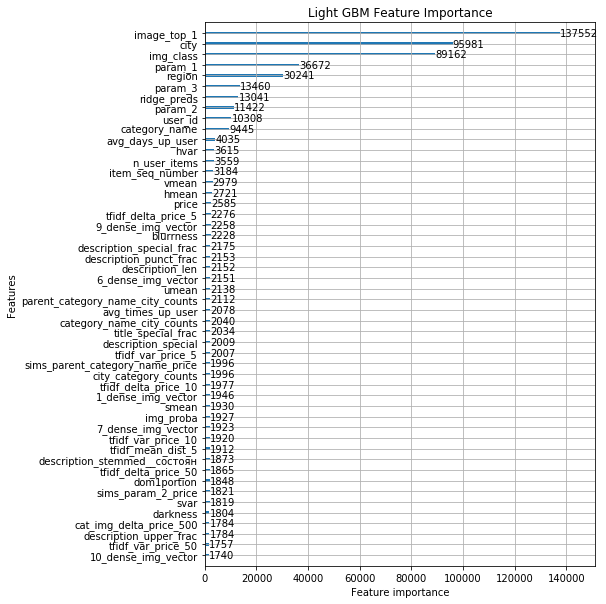

In [61]:
# Feature Importance Plot
f, ax = plt.subplots(figsize=[7,10])
lgb.plot_importance(lgb_clf, max_num_features=50, ax=ax)
plt.title("Light GBM Feature Importance")
plt.savefig('feature_import.png')

In [62]:
best_tree_count = lgb_clf.best_iteration
best_tree_count

2127

In [63]:
lgsub = pd.DataFrame(lgb_clf.predict(testing), columns=["deal_probability"],index=testdex)
lgsub['deal_probability'].clip(0.0, 1.0, inplace=True) # Between 0 and 1
lgsub.to_csv("lgsub_with_features.csv",index=True,header=True)

/usr/local/lib/python3.6/site-packages/lightgbm/basic.py:450: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


# Using folds

In [114]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 7, shuffle=True, random_state=42)

models = []
fold_pred = []
fold_val = []
w = np.zeros((testing.shape[0]))

X = csr_matrix(X)

In [ ]:
for train_index, test_index in kf.split(X, y):
    print("TRAIN: ", len(train_index), "TEST:", len(test_index))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    lgtrain = lgb.Dataset(X_train, y_train,
                          feature_name = tfvocab,
                          categorical_feature = categorical)

    lgb_clf = lgb.train(
        lgbm_params,
        lgtrain,
        num_boost_round=best_tree_count, # 2454
    )

    pred = lgb_clf.predict(X_test)
    w += lgb_clf.predict(testing)
    
    models.append(lgb_clf)
    fold_pred.append(pred)
    fold_val.append(test_index)
    
    print(mean_squared_error(y_test, pred))
w /= 7

TRAIN:  1288649 TEST: 214775


/usr/local/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


0.0458989138104
TRAIN:  1288649 TEST: 214775


In [226]:
with open("folds.pickle", "wb") as f:
    pickle.dump(fold_pred, f)
    pickle.dump(fold_val, f)
    pickle.dump(models, f)

In [79]:
import pickle
with open("folds.pickle", "rb") as f:
    fold_pred = pickle.load(f)
    fold_val = pickle.load(f)
    models = pickle.load(f)

In [81]:
oofs = np.empty((len(traindex), len(fold_val)))
oof_predictions = np.zeros((len(testdex), len(fold_val)))
oofs.fill(np.nan)

for i in range(len(fold_val)):
    oofs[fold_val[i], i] = fold_pred[i]
    oof_predictions[:, i] = models[i].predict(testing)

/usr/local/lib/python3.6/site-packages/lightgbm/basic.py:450: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


In [90]:
pd.DataFrame({"item_id": np.array(traindex),
              "train_off_predictions": np.nanmean(oofs, axis=1)}).to_csv("train_oof_predictions2.csv")
pd.DataFrame({"item_id": np.array(testdex),
              "test_predictions": np.nanmean(oof_predictions, axis=1)}).to_csv("test_predictions_folds2.csv")

In [109]:
lgsub = pd.DataFrame(w, columns=["deal_probability"], index=testdex)
lgsub['deal_probability'].clip(0.0, 1.0, inplace=True)
lgsub.to_csv("lgsub_with_features.csv",index=True,header=True)

In [230]:
gc.collect()

118

In [129]:
# !kaggle competitions submit -c avito-demand-prediction -f lgsub_with_features.csv -m LGBBaselineWithFeatures